In [180]:
from sklearn.datasets import load_boston
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt

In [71]:
%matplotlib inline

In [67]:
data = load_boston()

In [68]:
X = data['data']
y = data['target']

In [171]:

class DecisionTree(BaseEstimator):
    '''
    Simple decision tree regressor with MSE rule and random best split by one feature,
    X and y -Features and Targets, must have numpy.ndarray class
    n_partitions - Number of partitions in each split, n_partitions = number of values if None 
    err_f - H(R) - Inhomogeneity function
    '''
    class Node(object):
        def __init__(self, X, y, err_f, n_partitions, max_depth):
            self.isLeaf = True
            self.err_f = err_f
            self.max_depth = max_depth
            self.n_partitions = n_partitions
            if self.n_partitions:
                self.n_partitions = max(2, self.n_partitions)
                self.quants = np.arange(self.n_partitions)/(self.n_partitions - 1)
            self.X = X
            self.y = y
            self.split()
            
        def partition_err(self, X_slice, bins):
            Q = len(X_slice)
            nR = np.sum(bins)
            nL = Q - nR
            R = self.y[bins > 0]
            L = self.y[bins < 1]
            
            return nL/Q*self.err_f(L, np.ones_like(L)*np.mean(L)) + nR/Q*self.err_f(R, np.ones_like(R)*np.mean(R))
                
        def split(self):
            if self.max_depth == 1 or len(self.X) <= 1:
                self.predict = np.mean(y)
                return
            self.isLeaf = False
            self.split_err = np.inf
            for ft in range(len(self.X[0])):
                X_feature_slice = self.X[:,ft]
                sorted_slice = np.sort(list(set(X_feature_slice)))[:-1]
                
                if len(sorted_slice) <= 1:
                    continue
                    
                if  self.n_partitions:
                    partitions = sorted_slice[np.array(self.quants * (len(sorted_slice)-1),dtype=int)]
                else:
                    partitions = sorted_slice
                    
                for bound in partitions:
                    bins =  (X_feature_slice > bound)
                    error = self.partition_err(X_feature_slice, bins)
                    if error < self.split_err:
                        self.split_err = error
                        self.split_bins = bins
                        self.split_feature = ft
                        self.split_bound = bound
            
            if self.split_err == np.inf:
                self.predict == np.mean(y)
                return
            
            md = self.max_depth
            if md:
                md -= 1
            self.Left = DecisionTree.Node(X[self.split_bins < 1], y[self.split_bins < 1], 
                                          self.err_f, self.n_partitions, md)
            self.Right = DecisionTree.Node(X[self.split_bins > 0], y[self.split_bins > 0], 
                                           self.err_f, self.n_partitions, md) 
            
    def __init__(self, err_f = mean_squared_error, n_partitions=None,max_depth=None):
        self.err_f = err_f
        self.max_depth = max_depth
        self.n_partitions = n_partitions
    def fit(self, X, y):
        self.root = self.Node(X,y,self.err_f, self.n_partitions, self.max_depth)
    def predict(self, X):
        y = []
        for x in X:
            cur = self.root
            while not cur.isLeaf:
                if x[cur.split_feature] > cur.split_bound:
                    cur = cur.Right
                else:
                    cur = cur.Left
            y.append(cur.predict)
        return np.array(y)

In [185]:
def benchmark(clfr,params):
    scores = []
    for h in range(1,5):
        params['max_depth'] = h
        clf = clfr(**params)
        scores.append(np.mean(cross_validation.cross_val_score(clf,X,y,n_jobs=4,scoring=make_scorer(mean_squared_error),cv=4)))
        print(np.array(scores).shape)
    plt.plot(np.arange(1,5),scores)

(1,)


/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 379
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 380
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 380
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 379
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65

(2,)


/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 379
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 379
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 380
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 380
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65

(3,)


/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 379
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 379
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 380
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 380
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:65

(4,)
(1,)
(2,)
(3,)
(4,)


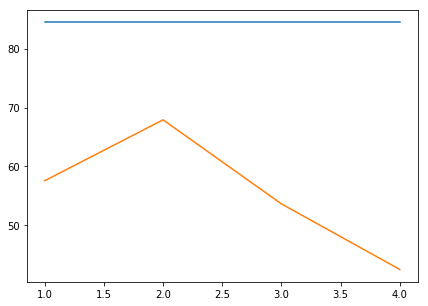

In [192]:
plt.figure(figsize=(7,5))
benchmark(DecisionTree, {'n_partitions':10})
benchmark(DecisionTreeRegressor, {'max_features':1,'random_state':1})
plt.show()